In [9]:
from cobra import Reaction, Metabolite
from cobra.io import read_sbml_model
import model_methods
from model_methods import get_base_model
import warnings

warnings.filterwarnings("ignore", ".*not in.*", UserWarning)


model_old = read_sbml_model('iNF517.xml')
model = get_base_model()

original_medium = model.medium
original_objective = model_old.objective
upd_objective = model.objective

current_medium = model.medium

In [10]:
model.objective = model.reactions.DM_mqn7_c
production_mqn7c = model.optimize().objective_value
production_mqn7c

0.03999999999999991

## Finding the best metabolite to adjust

In [11]:
import copy

# Get the initial medium
initial_medium = copy.deepcopy(model.medium)

# Define the step for concentration increase
step_size = 1

# Define the threshold for the objective value
threshold_value = model.optimize().objective_value

# Dictionary to store the results
metabolite_changes = {}

# Iterate over each metabolite in the initial medium
for metabolite, concentration in initial_medium.items():
    # Copy the initial medium for each iteration
    medium_copy = copy.deepcopy(initial_medium)

    # Iterate over the increasing steps
    for step in range(1, 100):
        # Calculate the new concentration
        new_concentration = concentration + step_size * step

        # Update the medium copy with the new concentration for the current metabolite
        medium_copy[metabolite] = new_concentration
        model.medium = medium_copy

        # Optimize the model and get the objective value
        objective_value = model.optimize().objective_value

        # Check if the objective value exceeds the threshold
        if objective_value > threshold_value:
            metabolite_changes[metabolite] = new_concentration
            threshold_value = objective_value

# Print the results
for metabolite, concentration in metabolite_changes.items():
    print(f"Increasing {metabolite} to {concentration} results in an objective value > {threshold_value}")

Increasing EX_arg__L_e to 1.02 results in an objective value > 0.14913818493150693
Increasing EX_glu__L_e to 17.05 results in an objective value > 0.14913818493150693


* As can be seen, arginine and glutamate gave the best results.

## Glutamate target value

In [12]:
# Get the initial medium
initial_medium = copy.deepcopy(model.medium)

# Define the step for concentration increase
step_size = 1

# Define the threshold for the objective value
threshold_value = model.optimize().objective_value

# Dictionary to store the results
metabolite_changes = {}

glu_amounts = []
obj_val_glu = []

# Iterate over each metabolite in the initial medium
for metabolite, concentration in initial_medium.items():
    if metabolite == "EX_glu__L_e":
        # Copy the initial medium for each iteration
        medium_copy = copy.deepcopy(initial_medium)
        
        # Iterate over the increasing steps
        for step in range(1, 100):
            # Calculate the new concentration
            new_concentration = concentration + step_size * step
            glu_amounts.append(new_concentration)

            # Update the medium copy with the new concentration for the current metabolite
            medium_copy[metabolite] = new_concentration
            model.medium = medium_copy

            # Optimize the model and get the objective value
            objective_value = model.optimize().objective_value
            obj_val_glu.append(objective_value)

            # Check if the objective value exceeds the threshold
            if objective_value > threshold_value:
                metabolite_changes[metabolite] = new_concentration
                threshold_value = objective_value

# Print the results
for metabolite, concentration in metabolite_changes.items():
    print(f"Increasing {metabolite} to {concentration} results in an objective value > {threshold_value}")

Increasing EX_glu__L_e to 16.05 results in an objective value > 0.149138184931507


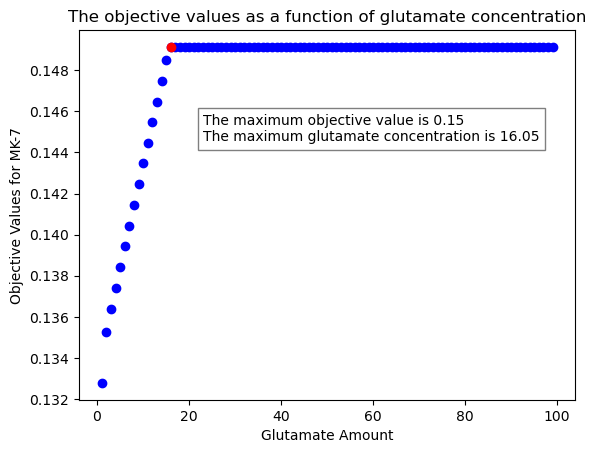

In [13]:
import matplotlib.pyplot as plt

plt.scatter(glu_amounts, obj_val_glu, color='blue', marker='o')

# Find the index of the maximum value in obj_val_glu
max_index = obj_val_glu.index(max(obj_val_glu))

# Highlight and label the point with the maximum objective value

plt.scatter(glu_amounts[max_index], max(obj_val_glu), color='red', marker='o')

# Add labels and title
plt.xlabel('Glutamate Amount')
plt.ylabel('Objective Values for MK-7')
plt.title('The objective values as a function of glutamate concentration')

text_box = f"The maximum objective value is {obj_val_glu[max_index]:.2f}\nThe maximum glutamate concentration is {glu_amounts[max_index]}"
plt.text(0.25, 0.7, text_box, bbox=dict(facecolor='white', alpha=0.5), transform=plt.gca().transAxes)

# Display the plot
plt.show()

* It is visible from the graph that an increase in glutamate to a value higher than 16.05 does not improve the production. So, 16.05 should be set as a target value.

In [14]:
original_medium['EX_glu__L_e'] = 16.05
model.medium = original_medium

## Carbon sources change

In [15]:
# carbon sources that were found in the model
c_sources = ['EX_glc__D_e' ,'EX_succ_e', 'EX_fru_e',
             'EX_gln__L_e', 'EX_sucr_e', 'EX_lac__L_e', 'EX_mal__L_e']
c_names = [ 'glucose', 'succinate' , 'fructose', 
           'glutamine', 'sucrose', 'lactate', 'malate-L']
number = [0,1,2,3,4,5,6]

for n in number:
    medium = model.medium
    with model:
        # setting glucose to a low level, and c_source to a higher one
            medium['EX_glc__D_e'] = 1
            medium[c_sources[n]] = 10
            model.medium = medium
        # defining the production of vitamin K2
            production_mqn7c = model.optimize().objective_value
            print('The Vitamin K2 production using {} as a primary carbon source yields {:.2f} mmol/ gDw*h'.format(c_names[n], production_mqn7c))
            
        # checking the biomass production with that carbon source   
            model.objective = original_objective
            solution = model.optimize()
            biomass_production = model.optimize().objective_value
            print('The biomass production using {} as a primary carbon source yields {:.2f} mmol/ gDw*h \n'.format(c_names[n], biomass_production))

The Vitamin K2 production using glucose as a primary carbon source yields 0.42 mmol/ gDw*h
The biomass production using glucose as a primary carbon source yields 0.10 mmol/ gDw*h 

The Vitamin K2 production using succinate as a primary carbon source yields 0.02 mmol/ gDw*h
The biomass production using succinate as a primary carbon source yields 0.02 mmol/ gDw*h 

The Vitamin K2 production using fructose as a primary carbon source yields 0.43 mmol/ gDw*h
The biomass production using fructose as a primary carbon source yields 0.10 mmol/ gDw*h 

The Vitamin K2 production using glutamine as a primary carbon source yields 0.02 mmol/ gDw*h
The biomass production using glutamine as a primary carbon source yields 0.02 mmol/ gDw*h 

The Vitamin K2 production using sucrose as a primary carbon source yields 0.57 mmol/ gDw*h
The biomass production using sucrose as a primary carbon source yields 0.10 mmol/ gDw*h 

The Vitamin K2 production using lactate as a primary carbon source yields 0.19 mmol/ 

* As can be seen, the highest production was achieved with sucrose.

It was mentioned that raffinose addition increased the growth rate of L. lactis A12 (Passerini, et al., 2013). Unfortunately, it was not found for the current model, and the metabolite ("raffin") was not stated to be present in L. lactis in BiGG database:

In [16]:
original_medium['EX_raffin_e'] = 1
model.medium = original_medium

KeyError: 'EX_raffin_e'

In [17]:
# updating the model without raffinose
original_medium = model.medium
original_medium['EX_glu__L_e'] = 16.05
model.medium = original_medium

In [18]:
# adding sucrose, as it was not present in the original model
original_medium['EX_sucr_e'] = 1
model.medium = original_medium

## Sucrose target value

In [19]:
# Get the initial medium
initial_medium = copy.deepcopy(model.medium)

# Define the step for concentration increase
step_size = 1

# Define the threshold for the objective value
threshold_value = model.optimize().objective_value

# Dictionary to store the results
metabolite_changes = {}

sucr_amounts = []
obj_val_sucr = []

# Iterate over each metabolite in the initial medium
for metabolite, concentration in initial_medium.items():
    if metabolite == "EX_sucr_e":
        # Copy the initial medium for each iteration
        medium_copy = copy.deepcopy(initial_medium)
        
        # Iterate over the increasing steps
        for step in range(1, 500):
            # Calculate the new concentration
            new_concentration = concentration + step_size * step
            sucr_amounts.append(new_concentration)

            # Update the medium copy with the new concentration for the current metabolite
            medium_copy[metabolite] = new_concentration
            model.medium = medium_copy

            # Optimize the model and get the objective value
            objective_value = model.optimize().objective_value
            obj_val_sucr.append(objective_value)

            # Check if the objective value exceeds the threshold
            if objective_value > threshold_value:
                metabolite_changes[metabolite] = new_concentration
                threshold_value = objective_value

# Print the results
for metabolite, concentration in metabolite_changes.items():
    print(f"Increasing {metabolite} to {concentration} results in an objective value > {threshold_value}")

Increasing EX_sucr_e to 284 results in an objective value > 11.09834047330094


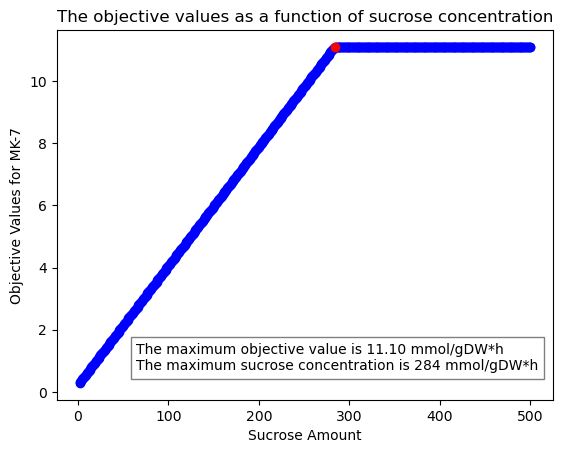

In [31]:
import matplotlib.pyplot as plt

plt.scatter(sucr_amounts, obj_val_sucr, color='blue', marker='o')

# Find the index of the maximum value in obj_val_glu
max_index = obj_val_sucr.index(max(obj_val_sucr))

# Highlight and label the point with the maximum objective value

plt.scatter(sucr_amounts[max_index], max(obj_val_sucr), color='red', marker='o')

# Add labels and title
plt.xlabel('Sucrose Amount')
plt.ylabel('Objective Values for MK-7')
plt.title('The objective values as a function of sucrose concentration')

text_box = f"The maximum objective value is {obj_val_sucr[max_index]:.2f} mmol/gDW*h \nThe maximum sucrose concentration is {sucr_amounts[max_index]} mmol/gDW*h"
plt.text(0.16, 0.08, text_box, bbox=dict(facecolor='white', alpha=0.5), transform=plt.gca().transAxes)

# Display the plot
plt.show()

In [21]:
original_medium['EX_sucr_e'] = 284
model.medium = original_medium

## New objective value

In [22]:
production_mqn7c = model.optimize().objective_value
production_mqn7c

11.09834047330093

<font size=3>

In optimizing MK-7 production in *L. lactis*, the addition of glutamate and subsequent incorporation of sucrose resulted in substantial improvements. The introduction of sucrose proved to be the most effective among iterated carbon sources.
    
</font> 

## References

Passerini, D., Coddeville, M., Le Bourgeois, P., Loubière, P., Ritzenthaler, P., Fontagné-Faucher, C., Daveran-Mingot, M. L., & Cocaign-Bousquet, M. (2013). The carbohydrate metabolism signature of lactococcus lactis strain A12 reveals its sourdough ecosystem origin. Applied and environmental microbiology, 79(19), 5844–5852. https://doi.org/10.1128/AEM.01560-13